In [1]:
%load_ext autoreload
%autoreload 2

# Neural Network For MoA Prediction

In [2]:
import os
import glob
import itertools
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, SubsetRandomSampler

import torch
import torch.nn as nn
import torch.nn.functional as F

import ms2_model
from ms2_model import Net3072
from ms2_dataset import EmbedVecDataset

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

Define paths, file names and random_state used in the notebook.

In [3]:
data_dir = "~/siads696/data"
image_dir = "/home/mhuebsch/SIADS696_Milestone2/images"
train_test_split = "compound_moas_trainVtest.csv"

# Same training and test files used in gridsearch crossvalidation
train_data_file = "full_train_moa.parquet"
test_data_file = "full_test.parquet"
cross_val_file_pattern = "nn_Net3072_cv_results_*.parquet"
random_state = 764

Check device and use GPU if available.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


Load the training and test datasets.  
Load the gridsearch chunks and concatenate to create the result dataframe.

In [5]:
df_train_data = pd.read_parquet(os.path.join(data_dir, train_data_file))
df_test_data = pd.read_parquet(os.path.join(data_dir, test_data_file))

# Load and concatenate the gridsearch result files
cv_dfs = list()
for file in glob.glob(os.path.join(os.path.expanduser(data_dir), cross_val_file_pattern)):
    cv_dfs.append(pd.read_parquet(file))
df_cross_val = pd.concat(cv_dfs, ignore_index=True)

In [6]:
# fix my stupid typos ;-)
df_cross_val = df_cross_val.rename(columns={"trianing_loss mean": "training_loss mean", "validaton_acc mean": "validation_acc mean"})

In [7]:
df_cross_val["abs_diff_acc"] = np.absolute(df_cross_val["training_acc mean"] - df_cross_val["validation_acc mean"])
df_cross_val["abs_diff_loss"] = np.absolute(df_cross_val["training_loss mean"] - df_cross_val["validation_loss mean"])

Sort the result by ascending ´validation_loss mean´ to get the hyperparameters which minimize the loss.  
It can be noticed that the differenct between training and validation loss is quite large. We suspect that this mainly due to the amount of training and validation data. The validation is done on one compound which only contains 96 field of view embedding vectors.

In [8]:
df_cross_val = df_cross_val.sort_values(["validation_loss mean"], ascending=True)
df_cross_val

,learning_rate,batch_size,epochs,training_loss mean,training_loss std,training_acc mean,training_acc std,validation_loss mean,validation_loss std,validation_acc mean,validation_acc std,abs_diff_acc,abs_diff_loss
5,0.0001,32,20,0.400070,0.025809,0.871635,0.010226,2.349046,1.935855,0.452586,0.210243,0.419049,1.948977
4,0.0001,32,15,0.507703,0.026901,0.840206,0.010087,2.360785,1.751862,0.436063,0.206284,0.404143,1.853081
0,0.0010,32,15,0.660357,0.045892,0.771480,0.016558,2.650707,2.580449,0.459052,0.202707,0.312429,1.990350
2,0.0005,32,15,0.468980,0.035666,0.837157,0.013884,2.918109,2.657276,0.434267,0.212144,0.402890,2.449130
3,0.0005,32,20,0.400190,0.028545,0.858874,0.010361,2.945807,2.481233,0.452945,0.210084,0.405929,2.545617
1,0.0010,32,20,0.607356,0.041544,0.790278,0.015568,2.961155,2.572750,0.404274,0.184048,0.386003,2.353800


Get the hyperparameters leading to the lowest validation loss.

In [9]:
learning_rate = float(df_cross_val.iloc[0,0])
batch_size = int(df_cross_val.iloc[0,1])
epochs = int(df_cross_val.iloc[0,2])
print(f"Best validation loss parameters:\nLearning rate: {learning_rate}, batch size: {batch_size}, epochs: {epochs}")

Best validation loss parameters:
Learning rate: 0.0001, batch size: 32, epochs: 20


Get the MoAs in the training set.

In [10]:
moa_list = df_train_data[~df_train_data["Metadata_MoA"].isnull()].loc[:, "Metadata_MoA"].unique().tolist()
moa_dict = {moa: idx for moa, idx in zip(moa_list, range(len(moa_list)))}
n_classes = len(moa_dict.keys())

In [11]:
print("MoA labels:")
print(moa_dict)
print(f"Number of classes: {n_classes}")

MoA labels:
{'Protein degradation': 0, 'Kinase inhibitors': 1, 'Protein synthesis': 2, 'DNA replication': 3, 'DNA damage': 4, 'Microtubule destabilizers': 5, 'Actin disruptors': 6, 'Microtubule stabilizers': 7, 'Cholesterol-lowering': 8, 'Eg5 inhibitors': 9, 'Aurora kinase inhibitors': 10, 'Epithelial': 11, 'DMSO': 12}
Number of classes: 13


Create the training and test Dataset and Dataloader to be used in the training and test step.

In [12]:
train_dataset = EmbedVecDataset(df_train_data, "Metadata_MoA", "Z", moa_dict)
test_dataset = EmbedVecDataset(df_test_data, "Metadata_MoA", "Z", moa_dict)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Create the neural network model. Define the loss function and the optimizer.

In [14]:
torch.manual_seed(random_state)
model = Net3072(n_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/mhuebsch/.conda/envs/ms2/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Iterate through the epochs and record the training and test loss and accuracy.

In [15]:
%%time
training_records = list()
test_reocrds = list()
for epoch in range(epochs):
    train_loss, train_corr = ms2_model.train_model(model, optimizer, loss_func, train_dataloader, device)
    test_loss, test_corr = ms2_model.valid_model(model, loss_func, test_dataloader, device)
    training_loss = train_loss / len(train_dataloader.dataset)
    training_acc = train_corr / len(train_dataloader.dataset)
    testing_loss = test_loss / len(test_dataloader.dataset)
    testing_acc = test_corr / len(test_dataloader.dataset)
    training_records.append((training_loss, training_acc, testing_loss, testing_acc))

CPU times: user 5min 37s, sys: 717 ms, total: 5min 38s
Wall time: 5min 45s


Create the dataframe containing the training and test results.  
Plot the loss and accuracy curves.

In [16]:
df_training_data = pd.DataFrame.from_records(training_records, columns=["training_loss", "training_accuracy", "test_loss", "test_accuracy"])
df_training_data = df_training_data.reset_index()

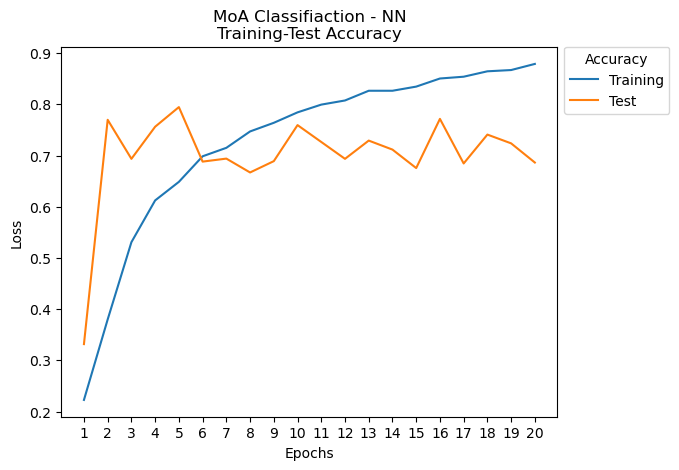

In [17]:
fig, ax = plt.subplots()
# lp = sns.lineplot(x="index", y="training_loss", data=df_training_data)
sns.lineplot(data=df_training_data["training_accuracy"], linestyle="solid", label="Training")
sns.lineplot(data=df_training_data["test_accuracy"], linestyle="solid", label="Test")
ax.set_xticks(range(len(df_training_data)))
ax.set_xticklabels(range(1, len(df_training_data)+1))
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(bbox_to_anchor= (1,1.02), title="Accuracy")
ax.set_title("MoA Classifiaction - NN\nTraining-Test Accuracy")
plt.savefig(os.path.join(image_dir, "nn_moa_accuracy.png"), bbox_inches="tight")
plt.show()

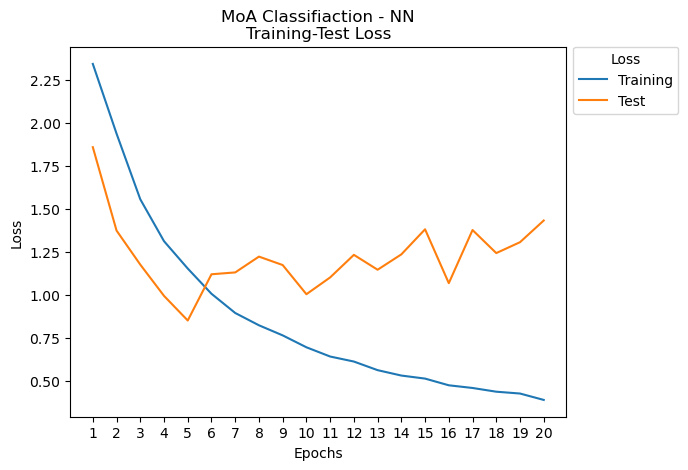

In [18]:
fig, ax = plt.subplots()
# lp = sns.lineplot(x="index", y="training_loss", data=df_training_data)
sns.lineplot(data=df_training_data["training_loss"], linestyle="solid", label="Training")
sns.lineplot(data=df_training_data["test_loss"], linestyle="solid", label="Test")
ax.set_xticks(range(len(df_training_data)))
ax.set_xticklabels(range(1, len(df_training_data)+1))
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(bbox_to_anchor= (1.24,1.02), title="Loss")
ax.set_title("MoA Classifiaction - NN\nTraining-Test Loss")
plt.savefig(os.path.join(image_dir, "nn_moa_loss.png"), bbox_inches="tight")
plt.show()

In contrast to the hyperparameters found in the gridsearch it looks like ´epoch = 5´ should be a good value. After epoch 5 the model starts to overfit heavily.  
Let's train the model on 5 epochs only and compare the results.

In [19]:
torch.manual_seed(random_state)
model_e5 = Net3072(n_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_e5.parameters(), lr=learning_rate)

Train a new model on 5 epochs only.

In [20]:
for epoch in range(5):
    train_loss, train_corr = ms2_model.train_model(model_e5, optimizer, loss_func, train_dataloader, device)
    training_loss = train_loss / len(train_dataloader.dataset)
    training_acc = train_corr / len(train_dataloader.dataset)
print(f"5 epochs training loss: {training_loss}")
print(f"5 epochs training accuracy: {training_acc}")

5 epochs training loss: 1.1261574207080152
5 epochs training accuracy: 0.6559971860710517


Test the new model using the test dataset.

In [21]:
test_loss, yhat = ms2_model.test_model(model_e5, loss_func, test_dataloader, device)

y_label = df_test_data["Metadata_MoA"].map(moa_dict).tolist()
accuracy = accuracy_score(y_label,yhat)
test_loss = test_loss / len(test_dataloader.dataset)
print(f"5 epoch test loss: {test_loss}")
print(f"5 epoch test accuracy {accuracy}")

5 epoch test loss: 0.9824676568542576
5 epoch test accuracy 0.746841155234657


Save the model.

In [22]:
torch.save(model_e5, "/home/mhuebsch/SIADS696_Milestone2/models/nn_Net3072_e5.pt")

Create the confusion matrix based on test dataset.

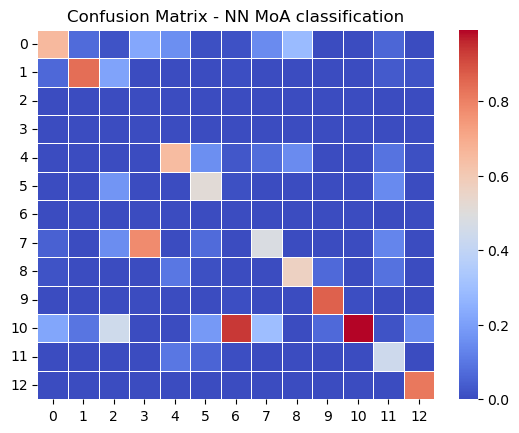

In [36]:
cm = confusion_matrix(y_label, yhat, normalize="pred")

tick_labels = list(moa_dict.keys())
# change label order to match other models confusion matrix
label_list = ["Actin disruptors", "Aurora kinase inhibitors", "Cholesterol-lowering", "DMSO", 
 "DNA damage", "DNA replication", "Eg5 inhibitors", "Epithelial", "Kinase inhibitors", 
 "Microtubule destabilizers", "Microtubule stabilizers", "Protein degradation", "Protein synthesis"]

df_cm = pd.DataFrame(cm, columns=tick_labels, index=tick_labels)

# Change order of the rows and columsn in the confusion matrix
df_cm = df_cm[label_list].reindex(label_list)

# Set new column names and index to match other modesl confusion matrix
new_lbl = list(range(n_classes))
df_cm.columns = new_lbl
df_cm = df_cm.set_index(pd.Index(new_lbl))

fig, ax = plt.subplots()
sns.heatmap(df_cm, cmap="coolwarm", linewidths=.7, linecolor="white")
ax.set_title("Confusion Matrix - NN MoA classification")
plt.yticks(rotation=0, ha="right")
plt.savefig(os.path.join(image_dir, "nn_moa_confmatrix.png"), bbox_inches="tight")
plt.show()

In [25]:
print(model_e5)

Net3072(
  (linear_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=13, bias=True)
  )
)
